# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
mnist_train

<_BatchDataset element_spec=(TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>

# Model creation

In [ ]:
from keras.api._v2.keras import activations
# test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=1))
cnn_model.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128,activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(NUM_CLASSES))

# Build fully connected student.
fc_model = tf.keras.Sequential()


# your code start from here for step 2
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784,activation='relu'))
fc_model.add(tf.keras.layers.Dense(784,activation='relu'))
fc_model.add(tf.keras.layers.Dense(NUM_CLASSES))




# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  #cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(subclass_logits, labels))
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits))
  #print(labels.shape)
  #print(subclass_logits.shape)



  return cross_entropy_loss_value

# Student loss function

In [ ]:
#test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
 ##########################
 #ZhixiangChi PengsongZhang
 #https://github.com/universea/ECE1512_2022F_ProjectRepo_ZhixiangChi_PengsongZhang/blob/main/Project_A/Task1.ipynb
 ##########################
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)
  #print(student_subclass_logits.shape)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  #cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(student_subclass_logits, labels))
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  student_loss = ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

  return student_loss

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value,model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

  return num_correct / num_total * 100

# Training models

In [ ]:
# your code start from here for step 5
train_and_evaluate(cnn_model,compute_teacher_loss)


Epoch 1: 

Class_accuracy: 98.35%
Epoch 2: Class_accuracy: 98.75%
Epoch 3: Class_accuracy: 98.82%
Epoch 4: Class_accuracy: 99.01%
Epoch 5: Class_accuracy: 98.98%
Epoch 6: Class_accuracy: 99.10%
Epoch 7: Class_accuracy: 99.13%
Epoch 8: Class_accuracy: 99.07%
Epoch 9: Class_accuracy: 99.08%
Epoch 10: Class_accuracy: 99.16%
Epoch 11: Class_accuracy: 99.30%
Epoch 12: Class_accuracy: 99.25%


<tf.Tensor: shape=(), dtype=float32, numpy=99.299995>

In [ ]:
ALPHA = 0.7
DISTILLATION_TEMPERATURE = 10
print('Alpha = ' + str(0.7) + ' Temperature = ' + str(10))
train_and_evaluate(fc_model, compute_student_loss)

Alpha = 0.7 Temperature = 10
Epoch 1: Class_accuracy: 96.71%
Epoch 2: Class_accuracy: 97.78%
Epoch 3: Class_accuracy: 98.08%
Epoch 4: Class_accuracy: 98.36%
Epoch 5: Class_accuracy: 98.46%
Epoch 6: Class_accuracy: 98.49%
Epoch 7: Class_accuracy: 98.46%
Epoch 8: Class_accuracy: 98.59%
Epoch 9: Class_accuracy: 98.47%
Epoch 10: Class_accuracy: 98.64%
Epoch 11: Class_accuracy: 98.70%
Epoch 12: Class_accuracy: 98.65%


<tf.Tensor: shape=(), dtype=float32, numpy=98.7>

In [ ]:
'''
for a in [0.1, 0.3, 0.5, 0.7]:
  for t in [2, 4, 10, 100]:
    ALPHA = a
    DISTILLATION_TEMPERATURE = t
    print('Alpha = ' + str(a) + ' Temperature = ' + str(t))
    train_and_evaluate(fc_model, compute_student_loss)
'''

"\nfor a in [0.1, 0.3, 0.5, 0.7]:\n  for t in [2, 4, 10, 100]:\n    ALPHA = a\n    DISTILLATION_TEMPERATURE = t\n    print('Alpha = ' + str(a) + ' Temperature = ' + str(t))\n    train_and_evaluate(fc_model, compute_student_loss)\n"

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ALPHA = 0.5
accuracy_list = []
for t in [1, 2, 4, 16, 32, 64]:
  DISTILLATION_TEMPERATURE = t
  accuracy_list.append(train_and_evaluate(fc_model, compute_student_loss))

In [ ]:
accuracy_list

[<tf.Tensor: shape=(), dtype=float32, numpy=98.77>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.94>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.96>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.99>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.99>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.97>]

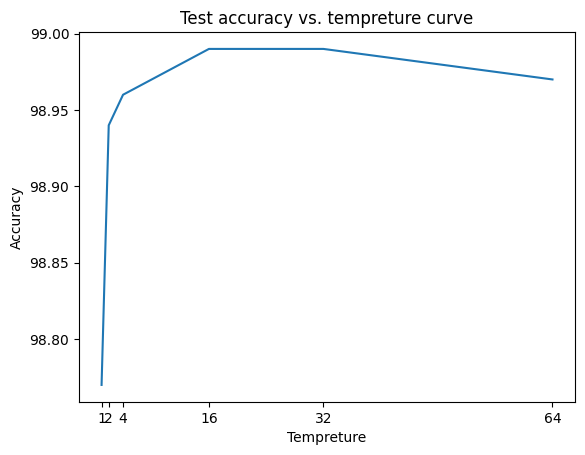

In [ ]:
import math
import matplotlib.pyplot as plt
x_axis = [1, 2, 4, 16, 32, 64]
plt.title("Test accuracy vs. tempreture curve")
plt.plot(x_axis,accuracy_list)
#new_list = range(math.floor(min(x_axis)), math.ceil(max(x_axis))+1)
plt.xticks(x_axis)
plt.xlabel('Tempreture')
plt.ylabel('Accuracy')
plt.savefig("Test_accuracy_vs_t.png")
plt.show()

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(NUM_CLASSES))


#test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return cross_entropy_loss


acc_before_kd = train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)
acc_before_kd

Epoch 1: Class_accuracy: 96.99%
Epoch 2: Class_accuracy: 97.60%
Epoch 3: Class_accuracy: 97.64%
Epoch 4: Class_accuracy: 97.92%
Epoch 5: Class_accuracy: 97.93%
Epoch 6: Class_accuracy: 98.41%
Epoch 7: Class_accuracy: 97.87%
Epoch 8: Class_accuracy: 97.88%
Epoch 9: Class_accuracy: 97.97%
Epoch 10: Class_accuracy: 97.98%
Epoch 11: Class_accuracy: 97.85%
Epoch 12: Class_accuracy: 97.85%


<tf.Tensor: shape=(), dtype=float32, numpy=98.409996>

In [ ]:
pip install py-markdown-table

In [ ]:
from py_markdown_table.markdown_table import markdown_table
data = [
    {
        "Temperature = 64, Alpha = 0.5 ": "Test Accuracy",
        "Student Model before KD": '{:.2f}%'.format(acc_before_kd),
        "Student Model after KD": '{:.2f}%'.format(accuracy_list[5]),
    },
]
table = markdown_table(data).get_markdown()
print(table)

```
+-----------------------------------------------------------------------------+
|Temperature = 64, Alpha = 0.5 |Student Model before KD|Student Model after KD|
+------------------------------+-----------------------+----------------------+
|         Test Accuracy        |         98.41%        |        98.97%        |
+-----------------------------------------------------------------------------+```


# Comparing the teacher and student model (number of of parameters and FLOPs)

In [ ]:
# your code start from here for step 8
###############
#Kaintels
#https://github.com/tensorflow/tensorflow/issues/32809
###############
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        #opts = tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter()
        #params = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops


In [ ]:
model = cnn_model
print("The FLOPs of Teacher model is:{}".format(get_flops(model)) ,flush=True )
model = fc_model
print("The FLOPs of Student model with KD is:{}".format(get_flops(model)) ,flush=True )
model = fc_model_no_distillation
print("The FLOPs of Student model without KD is:{}".format(get_flops(model)) ,flush=True )

The FLOPs of Teacher model is:30305354
The FLOPs of Student model with KD is:2475882
The FLOPs of Student model without KD is:2475882


In [ ]:
print('Teacher model:\n')
cnn_model.summary()
print('')
print('Student model with KD:\n')
fc_model.summary()
print('')
print('Student model without KD:\n')
fc_model_no_distillation.summary()

Teacher model:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 1081

# Implementing the state-of-the-art KD algorithm

In [ ]:
def train_and_evaluate(model, compute_loss_fn):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    #print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value,model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    #print("Class_accuracy: " + '{:.2f}%'.format(
        #num_correct / num_total * 100))
    #accuracy.append(num_correct / num_total * 100)
  return num_correct / num_total * 100

In [ ]:
# your code start from here for step 12
techer_acc_list = []
student_acc_list = []
epoch_list = [2,4,8,12,24]
for epoch in epoch_list:
  NUM_EPOCHS = epoch
  techer_acc_list.append(train_and_evaluate(cnn_model,compute_teacher_loss))
  NUM_EPOCHS = 12
  student_acc_list.append(train_and_evaluate(fc_model, compute_student_loss))
  #train_and_evaluate(fc_model, compute_student_loss)


In [ ]:
techer_acc_list

[<tf.Tensor: shape=(), dtype=float32, numpy=98.95>,
 <tf.Tensor: shape=(), dtype=float32, numpy=99.19>,
 <tf.Tensor: shape=(), dtype=float32, numpy=99.36>,
 <tf.Tensor: shape=(), dtype=float32, numpy=99.299995>,
 <tf.Tensor: shape=(), dtype=float32, numpy=99.35>]

In [ ]:
student_acc_list

[<tf.Tensor: shape=(), dtype=float32, numpy=98.77>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.95>,
 <tf.Tensor: shape=(), dtype=float32, numpy=99.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=99.07>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.979996>]

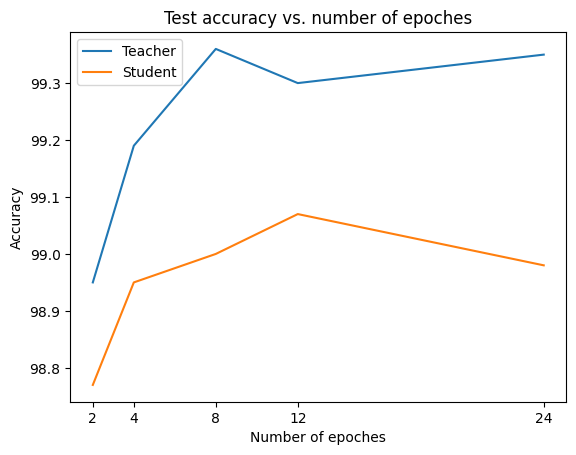

In [ ]:
import math
import matplotlib.pyplot as plt
plt.title("Test accuracy vs. number of epoches")
plt.plot(epoch_list,techer_acc_list,label = 'Teacher')
plt.plot(epoch_list,student_acc_list,label = 'Student')
#new_list = range(math.floor(min(x_axis)), math.ceil(max(x_axis))+1)
plt.xticks(epoch_list)
plt.xlabel('Number of epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# XAI method to explain models

In [ ]:
# your code start from here for step 13
